In [40]:
### Mount drive ###
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!pip3 list|grep tensorflow

Mounted at /content/drive
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.29.0        
tensorflow-probability        0.12.1        


In [46]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

### Some constants ###
lr = 1e-4
batch_size = 128
epochs = 100
img_shape = (28, 28, 1)
latent_dim = 100
num_classes = 10
num_img_to_gen = 16
g_weights_path = "/content/drive/My Drive/cgan_g.weights.hdf5" # change this
d_weights_path = "/content/drive/My Drive/cgan_d.weights.hdf5" # change this

# Building the models

## 1. Generator

In [8]:
def make_generator():
  latent_inputs = Input(shape=(latent_dim,))
  label_inputs  = Input(shape=(num_classes,))

  inputs = Concatenate(axis=-1)([latent_inputs, label_inputs])
  x = Dense(7*7*128, use_bias=False)(inputs)
  x = LeakyReLU(0.2)(x)
  x = Reshape(target_shape=(7,7,128))(x)

  ### Size = 14 x 14 x 64 ###
  x = Conv2DTranspose(64, kernel_size=4, strides=(2,2), padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)

  ### Size = 28 x 28 x 32 ###
  x = Conv2DTranspose(32, kernel_size=4, strides=(2,2), padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)

  ### Size = 28 x 28 x 1 ###
  x = Conv2D(img_shape[-1], kernel_size=4, padding='same', use_bias=False, activation='tanh')(x)
  model = Model(inputs=[latent_inputs, label_inputs], outputs=x, name='Generator')
  return model

G = make_generator()
print(G.summary())

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         689920      concatenate_2[0][0]      

## 2. Discriminator

In [24]:
def make_discriminator():
  image_inputs = Input(shape=img_shape)

  label_inputs = Input(shape=(num_classes,))
  labels = Dense(np.prod(img_shape))(label_inputs)
  labels = Reshape(target_shape=img_shape)(labels)

  inputs = Concatenate(axis=-1)([image_inputs, labels])
  print(inputs.shape)

  x = Conv2D(8, kernel_size=4, strides=(2,2), padding='same')(inputs)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(16, kernel_size=4, strides=(2,2), padding='same')(x)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.3)(x)

  x = Flatten()(x)
  x = Dense(1)(x)

  model = Model(inputs=[image_inputs, label_inputs], outputs=x, name='Discriminator')
  return model

D = make_discriminator()
print(D.summary())

(None, 28, 28, 2)
Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 784)          8624        input_38[0][0]                   
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 28, 28, 1)    0           dense_30[0][0]                   
____________________________________________________________________

# Create loss functions

In [25]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(D_fake):
  loss = bce(tf.ones_like(D_fake, dtype=tf.float32), D_fake)
  return loss

def discriminator_loss(D_real, D_fake):
  loss_real = bce(tf.ones_like(D_real, dtype=tf.float32), D_real)
  loss_fake = bce(tf.zeros_like(D_fake, dtype=tf.float32), D_fake)

  loss = loss_real + loss_fake
  return loss

# Prepare the dataset

In [35]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = (train_images - 127.5) / 127.5 # Normalize the images

train_labels = train_labels.reshape(-1,1)
train_labels = OneHotEncoder().fit_transform(train_labels).toarray()

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(40000).batch(batch_size)

# Training step

In [41]:
### Train just like how we train a DCGAN ###
g_opt = Adam(lr, beta_1=0.5, amsgrad=True)
d_opt = Adam(lr, beta_1=0.5, amsgrad=True)

def train_step(images, labels):
  noise = tf.random.normal([batch_size, latent_dim])

  with tf.GradientTape() as g_tape, tf.GradientTape()as d_tape:
    gen_images =  G([noise, labels], training=True)
    real_output = D([images, labels], training=True)
    fake_output = D([gen_images, labels], training=True)

    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)

  g_generator = g_tape.gradient(gen_loss, G.trainable_variables)
  g_discriminator = d_tape.gradient(dis_loss, D.trainable_variables)

  g_opt.apply_gradients(zip(g_generator, G.trainable_variables))
  d_opt.apply_gradients(zip(g_discriminator, D.trainable_variables))

  return gen_loss.numpy(), dis_loss.numpy()

In [44]:
def train(dataset):
  gifs = []
  
  for i in range(epochs):
    start = time.time()
    for j, (batchX, batchY) in enumerate(dataset):
      # Drop remaining 
      if (batchX.shape[0] != batch_size):
        continue 

      gen_loss, dis_loss = train_step(batchX, batchY)
      end = time.time()

      print(f'Batch #{j+1} | Epoch #[{i+1}/{epochs}] | G loss = {gen_loss}, D loss = {dis_loss} | time = {end-start}')

    print('--------------------------------------------------------------------------------------')

In [45]:
train(dataset)

Batch #1 | Epoch #[1/100] | G loss = 0.6456390619277954, D loss = 1.4316219091415405 | time = 0.38567233085632324
Batch #2 | Epoch #[1/100] | G loss = 0.6475459933280945, D loss = 1.4347929954528809 | time = 0.430680513381958
Batch #3 | Epoch #[1/100] | G loss = 0.6463892459869385, D loss = 1.4371577501296997 | time = 0.4760735034942627
Batch #4 | Epoch #[1/100] | G loss = 0.6467866897583008, D loss = 1.4331748485565186 | time = 0.5218114852905273
Batch #5 | Epoch #[1/100] | G loss = 0.6481492519378662, D loss = 1.4317125082015991 | time = 0.5688567161560059
Batch #6 | Epoch #[1/100] | G loss = 0.6417498588562012, D loss = 1.4475847482681274 | time = 0.6167042255401611
Batch #7 | Epoch #[1/100] | G loss = 0.6400225162506104, D loss = 1.4382869005203247 | time = 0.6596143245697021
Batch #8 | Epoch #[1/100] | G loss = 0.6450002193450928, D loss = 1.4366785287857056 | time = 0.7005045413970947
Batch #9 | Epoch #[1/100] | G loss = 0.6462128162384033, D loss = 1.4425303936004639 | time = 0.

SystemError: ignored

(16, 10)


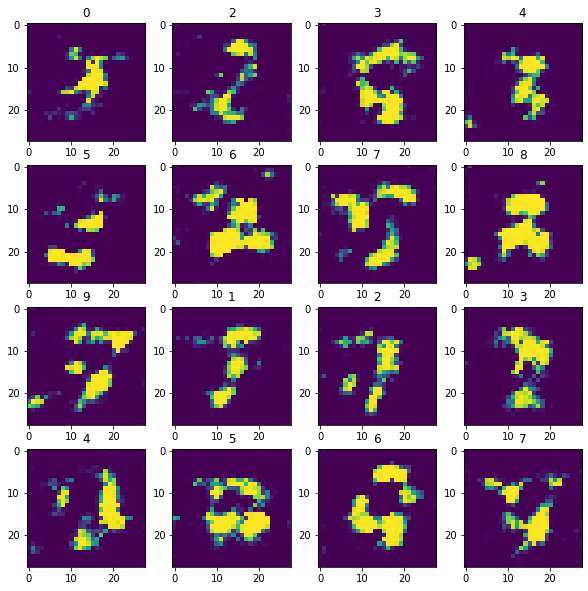

In [53]:
noise  = tf.random.normal([16, latent_dim])
labels = np.array([0,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7])
labels_onehot = OneHotEncoder().fit_transform(labels.reshape(-1,1)).toarray()
print(labels_onehot.shape)

predictions = G.predict([noise, labels_onehot])
predictions = predictions * 127.5 + 127.5
predictions = predictions.astype(np.uint8)

fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
  row = i // 4
  col = i %  4

  ax[row][col].imshow(predictions[i].reshape(28,28))
  ax[row][col].set_title(labels[i])

plt.show()